# Sysmon CSV Exploratory Data Analysis

## 📖 Overview

This notebook performs comprehensive exploratory data analysis on the processed Sysmon CSV file generated from notebook #2. The goal is to understand data quality, distributions, patterns, and characteristics that will inform our causal event search algorithm improvements.

### 🎯 Analysis Objectives

1. **Data Quality Assessment**: Missing values, data types, consistency
2. **Event Distribution Analysis**: EventID patterns, temporal distributions
3. **Process Relationship Mapping**: GUID/PID patterns, parent-child relationships
4. **Temporal Analysis**: Time patterns, event clustering, duration analysis
5. **Security Pattern Detection**: Suspicious activities, anomalous behaviors
6. **Data Integrity Validation**: GUID consistency, PID reuse detection
7. **Algorithm Input Assessment**: Data readiness for causal chain analysis

---

## 🛠️ Required Libraries

Import essential libraries for data analysis and visualization:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import re
from collections import Counter
import json

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


## 📁 Data Loading

Load the processed Sysmon CSV file and perform initial inspection:

In [2]:
# Load the CSV file with explicit data type specifications
csv_file = "sysmon-2025-05-04-000001.csv"
print(f"Loading Sysmon CSV: {csv_file}")

# Define explicit data types for proper CSV reading
dtype_spec = {
    # Integer columns that might have NaN values - use nullable Int64
    'ProcessId': 'Int64',
    'SourcePort': 'Int64', 
    'DestinationPort': 'Int64',
    'SourceProcessId': 'Int64',
    'ParentProcessId': 'Int64',
    'SourceThreadId': 'Int64',
    'TargetProcessId': 'Int64',
    
    # GUID columns - ensure string type
    'ProcessGuid': 'string',
    'SourceProcessGUID': 'string',
    'TargetProcessGUID': 'string', 
    'ParentProcessGuid': 'string',
    
    # Categorical columns for memory efficiency
    'Computer': 'category',
    'Protocol': 'category',
    'EventType': 'category'
}

try:
    df = pd.read_csv(csv_file, low_memory=False, dtype=dtype_spec)
    print(f"✅ Successfully loaded {len(df):,} records with correct data types")
    print(f"📊 Dataset shape: {df.shape}")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Verify data types were applied correctly
    print(f"\n🔍 Data Type Verification:")
    integer_cols = ['ProcessId', 'SourcePort', 'DestinationPort', 'SourceProcessId', 'ParentProcessId']
    for col in integer_cols:
        if col in df.columns:
            sample_val = df[col].dropna().iloc[0] if not df[col].dropna().empty else 'N/A'
            print(f"  {col}: {df[col].dtype} (sample: {sample_val})")
    
    guid_cols = ['ProcessGuid', 'SourceProcessGUID', 'TargetProcessGUID', 'ParentProcessGuid']
    for col in guid_cols:
        if col in df.columns:
            sample_val = df[col].dropna().iloc[0] if not df[col].dropna().empty else 'N/A'
            has_brackets = str(sample_val).startswith('{') if sample_val != 'N/A' else False
            print(f"  {col}: {df[col].dtype} (sample: {sample_val}, has_brackets: {has_brackets})")
            
except Exception as e:
    print(f"❌ Error loading CSV: {e}")
    df = None

Loading Sysmon CSV: sysmon-2025-05-04-000001.csv
✅ Successfully loaded 570,078 records with correct data types
📊 Dataset shape: (570078, 44)
💾 Memory usage: 846.22 MB

🔍 Data Type Verification:
  ProcessId: Int64 (sample: 1072)
  SourcePort: Int64 (sample: 60524)
  DestinationPort: Int64 (sample: 53)
  SourceProcessId: Int64 (sample: 596)
  ParentProcessId: Int64 (sample: 68)
  ProcessGuid: string (sample: acb80d05-4f8b-6817-1700-000000001600, has_brackets: False)
  SourceProcessGUID: string (sample: acb80d05-4f89-6817-0c00-000000001600, has_brackets: False)
  TargetProcessGUID: string (sample: acb80d05-4f9d-6817-3a00-000000001600, has_brackets: False)
  ParentProcessGuid: string (sample: acb80d05-4f8b-6817-1200-000000001600, has_brackets: False)


## 🔍 Basic Data Inspection

Examine the structure, data types, and basic statistics:

In [3]:
if df is not None:
    print("📋 DATASET OVERVIEW")
    print("=" * 50)
    print(f"Rows: {len(df):,}")
    print(f"Columns: {len(df.columns)}")
    print(f"\nColumn names:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:2}. {col}")
    
    print(f"\n🔢 DATA TYPES SUMMARY")
    print("=" * 30)
    print(df.dtypes.value_counts())
    
    print(f"\n📊 BASIC STATISTICS")
    print("=" * 30)
    print(f"EventID range: {df['EventID'].min()} - {df['EventID'].max()}")
    print(f"Unique EventIDs: {df['EventID'].nunique()}")
    print(f"Unique computers: {df['Computer'].nunique()}")
    print(f"Computer names: {list(df['Computer'].unique())}")

📋 DATASET OVERVIEW
Rows: 570,078
Columns: 44

Column names:
   1. EventID
   2. Computer
   3. UtcTime
   4. ProcessGuid
   5. ProcessId
   6. Image
   7. User
   8. Protocol
   9. SourceIsIpv6
  10. SourceIp
  11. SourceHostname
  12. SourcePort
  13. SourcePortName
  14. DestinationIsIpv6
  15. DestinationIp
  16. DestinationHostname
  17. DestinationPort
  18. DestinationPortName
  19. ImageLoaded
  20. OriginalFileName
  21. Hashes
  22. EventType
  23. TargetObject
  24. SourceProcessGUID
  25. SourceProcessId
  26. SourceImage
  27. TargetProcessGUID
  28. TargetProcessId
  29. TargetImage
  30. SourceThreadId
  31. SourceUser
  32. TargetUser
  33. PipeName
  34. CommandLine
  35. CurrentDirectory
  36. ParentProcessGuid
  37. ParentProcessId
  38. ParentImage
  39. ParentCommandLine
  40. TargetFilename
  41. CreationUtcTime
  42. Device
  43. PreviousCreationUtcTime
  44. Hash

🔢 DATA TYPES SUMMARY
object            29
Int64              7
string[python]     4
category        

In [4]:
# Display first few rows
if df is not None:
    print("📄 SAMPLE DATA (First 3 rows)")
    print("=" * 40)
    display(df.head(3))

📄 SAMPLE DATA (First 3 rows)


,EventID,Computer,UtcTime,ProcessGuid,ProcessId,Image,User,Protocol,SourceIsIpv6,SourceIp,SourceHostname,SourcePort,SourcePortName,DestinationIsIpv6,DestinationIp,DestinationHostname,DestinationPort,DestinationPortName,ImageLoaded,OriginalFileName,Hashes,EventType,TargetObject,SourceProcessGUID,SourceProcessId,SourceImage,TargetProcessGUID,TargetProcessId,TargetImage,SourceThreadId,SourceUser,TargetUser,PipeName,CommandLine,CurrentDirectory,ParentProcessGuid,ParentProcessId,ParentImage,ParentCommandLine,TargetFilename,CreationUtcTime,Device,PreviousCreationUtcTime,Hash
0,3,diskjockey.boombox.local,2025-05-04 11:30:01.044,acb80d05-4f8b-6817-1700-000000001600,1072,C:\Windows\System32\svchost.exe,NT AUTHORITY\NETWORK SERVICE,udp,False,10.1.0.4,diskjockey.boombox.local,60524,-,False,10.1.0.4,diskjockey.boombox.local,53,domain,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,diskjockey.boombox.local,2025-05-04 11:30:01.044,acb80d05-4f8b-6817-1700-000000001600,1072,C:\Windows\System32\svchost.exe,NT AUTHORITY\NETWORK SERVICE,udp,False,10.1.0.4,diskjockey.boombox.local,56341,-,False,10.1.0.4,diskjockey.boombox.local,53,domain,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,diskjockey.boombox.local,2025-05-04 11:30:01.044,acb80d05-4f9d-6817-3400-000000001600,2608,C:\Windows\System32\dns.exe,NT AUTHORITY\SYSTEM,udp,False,10.1.0.4,diskjockey.boombox.local,53,domain,False,10.1.0.4,diskjockey.boombox.local,60524,-,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Data types analysis
if df is not None:
    print("🔍 DETAILED DATA TYPES ANALYSIS")
    print("=" * 45)
    
    dtype_info = []
    for col in df.columns:
        dtype_info.append({
            'Column': col,
            'Data_Type': str(df[col].dtype),
            'Non_Null_Count': df[col].count(),
            'Null_Count': df[col].isnull().sum(),
            'Null_Percentage': (df[col].isnull().sum() / len(df)) * 100,
            'Unique_Values': df[col].nunique(),
            'Sample_Value': str(df[col].dropna().iloc[0]) if not df[col].dropna().empty else 'N/A'
        })
    
    dtype_df = pd.DataFrame(dtype_info)
    display(dtype_df)

🔍 DETAILED DATA TYPES ANALYSIS


,Column,Data_Type,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values,Sample_Value
0,EventID,int64,570078,0,0.000000,18,3
1,Computer,category,570078,0,0.000000,4,diskjockey.boombox.local
2,UtcTime,object,570072,6,0.001052,51239,2025-05-04 11:30:01.044
3,ProcessGuid,string,511777,58301,10.226846,1697,acb80d05-4f8b-6817-1700-000000001600
4,ProcessId,Int64,511777,58301,10.226846,1193,1072
5,Image,object,511777,58301,10.226846,248,C:\Windows\System32\svchost.exe
6,User,object,511770,58308,10.228074,13,NT AUTHORITY\NETWORK SERVICE
7,Protocol,category,16918,553160,97.032336,2,udp
8,SourceIsIpv6,object,16918,553160,97.032336,2,False
9,SourceIp,object,16918,553160,97.032336,17,10.1.0.4


## 📈 Event Distribution Analysis

Analyze the distribution of different Sysmon event types:

In [6]:
if df is not None:
    # EventID distribution
    print("📊 EVENT TYPE DISTRIBUTION")
    print("=" * 35)
    
    # Event descriptions for context
    event_descriptions = {
        1: 'Process Create',
        2: 'File Creation Time',
        3: 'Network Connection',
        4: 'Sysmon State Change',
        5: 'Process Terminate',
        6: 'Driver Load',
        7: 'Image Load',
        8: 'Create Remote Thread',
        9: 'Raw Access Read',
        10: 'Process Access',
        11: 'File Create',
        12: 'Registry Event (Object create/delete)',
        13: 'Registry Event (Value set)',
        14: 'Registry Event (Key/Value rename)',
        15: 'File Create Stream Hash',
        17: 'Pipe Create',
        18: 'Pipe Connect',
        19: 'WMI Event Filter',
        20: 'WMI Event Consumer',
        21: 'WMI Event Consumer To Filter',
        22: 'DNS Event',
        23: 'File Delete',
        24: 'Clipboard Change',
        25: 'Process Tampering'
    }
    
    event_counts = df['EventID'].value_counts().sort_index()
    event_percentages = df['EventID'].value_counts(normalize=True).sort_index() * 100
    
    print(f"{'EventID':<8} {'Description':<35} {'Count':<10} {'Percentage':<10}")
    print("-" * 70)
    
    for event_id in event_counts.index:
        desc = event_descriptions.get(event_id, 'Unknown Event')
        count = event_counts[event_id]
        pct = event_percentages[event_id]
        print(f"{event_id:<8} {desc:<35} {count:<10,} {pct:<10.2f}%")

📊 EVENT TYPE DISTRIBUTION
EventID  Description                         Count      Percentage
----------------------------------------------------------------------
1        Process Create                      1,461      0.26      %
2        File Creation Time                  57         0.01      %
3        Network Connection                  16,918     2.97      %
4        Sysmon State Change                 6          0.00      %
5        Process Terminate                   965        0.17      %
6        Driver Load                         481        0.08      %
7        Image Load                          63,892     11.21     %
9        Raw Access Read                     1,158      0.20      %
10       Process Access                      57,814     10.14     %
11       File Create                         4,271      0.75      %
12       Registry Event (Object create/delete) 289,812    50.84     %
13       Registry Event (Value set)          129,227    22.67     %
15       File Crea

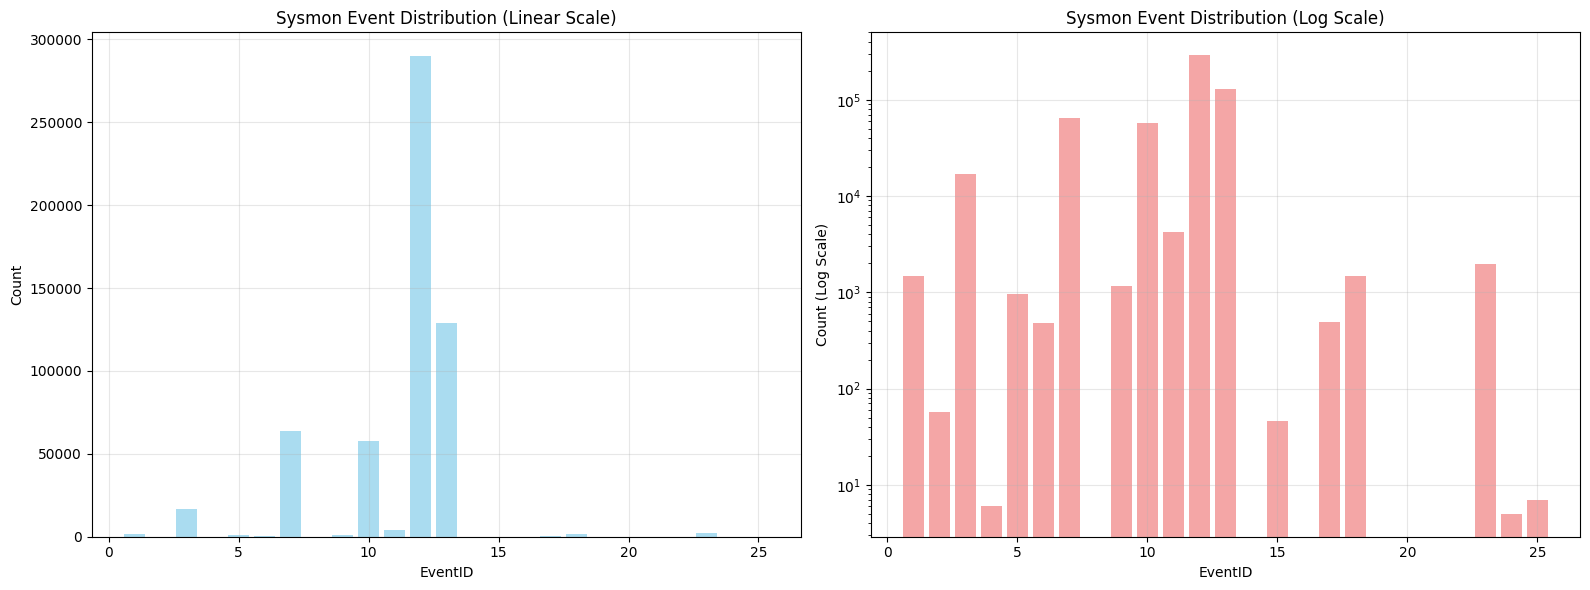


🔝 TOP 10 MOST COMMON EVENTS
EventID 12: Registry Event (Object create/delete) - 289,812 events (50.8%)
EventID 13: Registry Event (Value set) - 129,227 events (22.7%)
EventID 7: Image Load - 63,892 events (11.2%)
EventID 10: Process Access - 57,814 events (10.1%)
EventID 3: Network Connection - 16,918 events (3.0%)
EventID 11: File Create - 4,271 events (0.7%)
EventID 23: File Delete - 1,979 events (0.3%)
EventID 18: Pipe Connect - 1,491 events (0.3%)
EventID 1: Process Create - 1,461 events (0.3%)
EventID 9: Raw Access Read - 1,158 events (0.2%)


In [7]:
# Visualize event distribution
if df is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart of event counts
    event_counts = df['EventID'].value_counts().sort_index()
    ax1.bar(event_counts.index, event_counts.values, alpha=0.7, color='skyblue')
    ax1.set_xlabel('EventID')
    ax1.set_ylabel('Count')
    ax1.set_title('Sysmon Event Distribution (Linear Scale)')
    ax1.grid(True, alpha=0.3)
    
    # Log scale for better visibility
    ax2.bar(event_counts.index, event_counts.values, alpha=0.7, color='lightcoral')
    ax2.set_xlabel('EventID')
    ax2.set_ylabel('Count (Log Scale)')
    ax2.set_title('Sysmon Event Distribution (Log Scale)')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Top 10 most common events
    print("\n🔝 TOP 10 MOST COMMON EVENTS")
    print("=" * 35)
    top_events = df['EventID'].value_counts().head(10)
    for event_id, count in top_events.items():
        desc = event_descriptions.get(event_id, 'Unknown')
        pct = (count / len(df)) * 100
        print(f"EventID {event_id}: {desc} - {count:,} events ({pct:.1f}%)")

## ⏰ Temporal Analysis

Analyze timing patterns and temporal distributions:

In [8]:
if df is not None:
    # Convert UtcTime to datetime if not already
    if 'UtcTime' in df.columns:
        df['UtcTime'] = pd.to_datetime(df['UtcTime'], errors='coerce')
        
        print("⏰ TEMPORAL ANALYSIS")
        print("=" * 25)
        
        # Basic time statistics
        valid_times = df['UtcTime'].dropna()
        if len(valid_times) > 0:
            print(f"Time range: {valid_times.min()} to {valid_times.max()}")
            duration = valid_times.max() - valid_times.min()
            print(f"Total duration: {duration}")
            print(f"Events with valid timestamps: {len(valid_times):,} ({len(valid_times)/len(df)*100:.1f}%)")
            print(f"Events without timestamps: {df['UtcTime'].isnull().sum():,}")
            
            # Events per minute/hour statistics
            events_per_second = len(valid_times) / duration.total_seconds()
            events_per_minute = events_per_second * 60
            events_per_hour = events_per_minute * 60
            
            print(f"\n📊 Event Rate Statistics:")
            print(f"Events per second: {events_per_second:.2f}")
            print(f"Events per minute: {events_per_minute:.2f}")
            print(f"Events per hour: {events_per_hour:.2f}")
        else:
            print("⚠️ No valid timestamps found in UtcTime column")
    else:
        print("⚠️ UtcTime column not found")

⏰ TEMPORAL ANALYSIS
Time range: 2025-05-04 11:30:00.012000 to 2025-05-04 12:40:00.980000
Total duration: 0 days 01:10:00.968000
Events with valid timestamps: 570,072 (100.0%)
Events without timestamps: 6

📊 Event Rate Statistics:
Events per second: 135.70
Events per minute: 8142.01
Events per hour: 488520.55


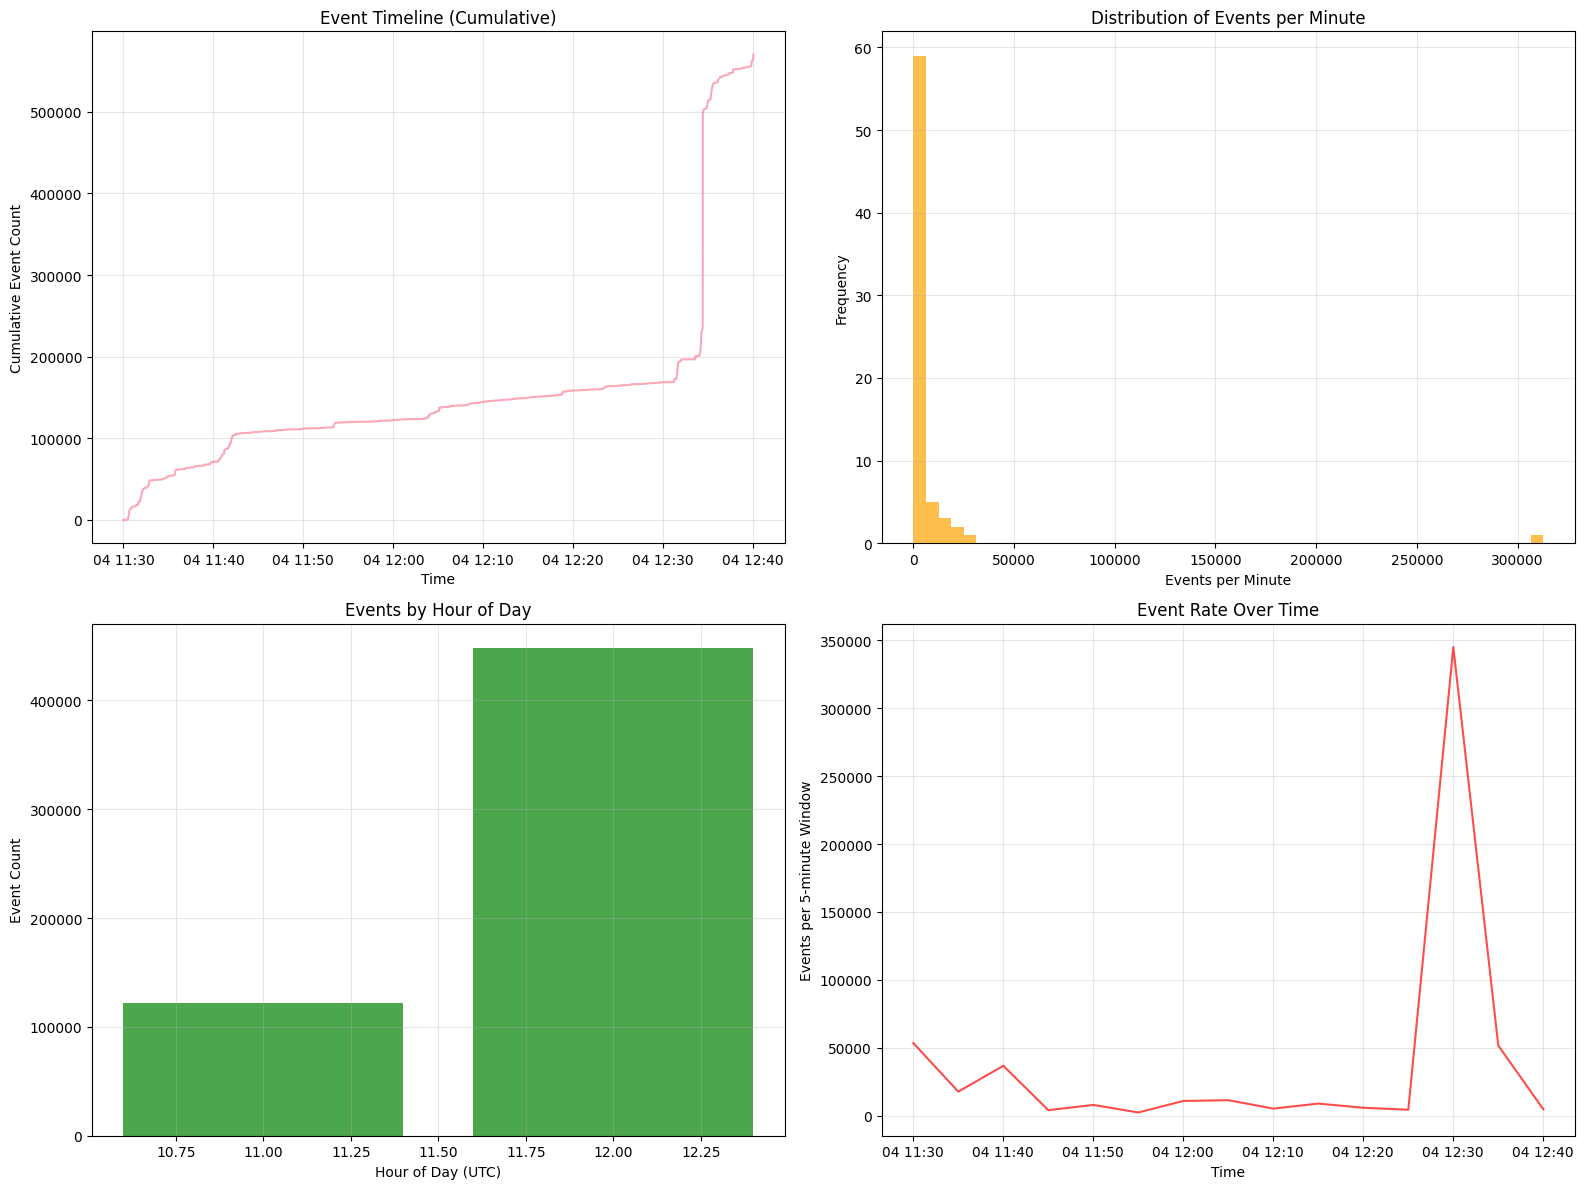


📈 Temporal Patterns Summary:
Peak events per minute: 312801
Average events per minute: 8029.2
Busiest hour: 12:00 UTC (447,891 events)
Quietest hour: 11:00 UTC (122,181 events)


In [9]:
# Temporal visualization
if df is not None and 'UtcTime' in df.columns:
    valid_times = df['UtcTime'].dropna()
    
    if len(valid_times) > 0:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Timeline of all events
        df_time_sorted = df[df['UtcTime'].notna()].sort_values('UtcTime')
        ax1.plot(df_time_sorted['UtcTime'], range(len(df_time_sorted)), alpha=0.6)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Cumulative Event Count')
        ax1.set_title('Event Timeline (Cumulative)')
        ax1.grid(True, alpha=0.3)
        
        # 2. Events per minute histogram
        df_resampled = df_time_sorted.set_index('UtcTime').resample('1T').size()
        ax2.hist(df_resampled.values, bins=50, alpha=0.7, color='orange')
        ax2.set_xlabel('Events per Minute')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distribution of Events per Minute')
        ax2.grid(True, alpha=0.3)
        
        # 3. Hourly pattern
        df_time_sorted['Hour'] = df_time_sorted['UtcTime'].dt.hour
        hourly_counts = df_time_sorted['Hour'].value_counts().sort_index()
        ax3.bar(hourly_counts.index, hourly_counts.values, alpha=0.7, color='green')
        ax3.set_xlabel('Hour of Day (UTC)')
        ax3.set_ylabel('Event Count')
        ax3.set_title('Events by Hour of Day')
        ax3.grid(True, alpha=0.3)
        
        # 4. Event rate over time (events per 5-minute window)
        event_rate = df_time_sorted.set_index('UtcTime').resample('5T').size()
        ax4.plot(event_rate.index, event_rate.values, alpha=0.7, color='red')
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Events per 5-minute Window')
        ax4.set_title('Event Rate Over Time')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📈 Temporal Patterns Summary:")
        print(f"Peak events per minute: {df_resampled.max()}")
        print(f"Average events per minute: {df_resampled.mean():.1f}")
        print(f"Busiest hour: {hourly_counts.idxmax()}:00 UTC ({hourly_counts.max():,} events)")
        print(f"Quietest hour: {hourly_counts.idxmin()}:00 UTC ({hourly_counts.min():,} events)")

## 🔗 Process Relationship Analysis

Analyze process relationships, GUIDs, and PIDs for causal chain validation:

In [10]:
if df is not None:
    print("🔗 PROCESS RELATIONSHIP ANALYSIS")
    print("=" * 40)
    
    # Analyze GUID/PID columns
    guid_pid_columns = [
        ('ProcessGuid', 'ProcessId'),
        ('ParentProcessGuid', 'ParentProcessId'),
        ('SourceProcessGUID', 'SourceProcessId'),
        ('TargetProcessGUID', 'TargetProcessId')
    ]
    
    relationship_stats = {}
    
    for guid_col, pid_col in guid_pid_columns:
        if guid_col in df.columns and pid_col in df.columns:
            # Count non-null pairs
            valid_pairs = df[(df[guid_col].notna()) & (df[pid_col].notna())]
            unique_guids = df[guid_col].nunique()
            unique_pids = df[pid_col].nunique()
            unique_pairs = valid_pairs.groupby([guid_col, pid_col]).size().shape[0]
            
            relationship_stats[guid_col.replace('ProcessGuid', '').replace('ProcessGUID', '')] = {
                'valid_pairs': len(valid_pairs),
                'unique_guids': unique_guids,
                'unique_pids': unique_pids,
                'unique_combinations': unique_pairs
            }
            
            print(f"\n{guid_col}/{pid_col}:")
            print(f"  Valid pairs: {len(valid_pairs):,}")
            print(f"  Unique GUIDs: {unique_guids:,}")
            print(f"  Unique PIDs: {unique_pids:,}")
            print(f"  Unique GUID-PID combinations: {unique_pairs:,}")
            
            # PID reuse analysis
            if unique_pids > 0 and unique_pairs > 0:
                reuse_ratio = unique_pairs / unique_pids
                print(f"  PID reuse ratio: {reuse_ratio:.2f} (>1 indicates PID reuse)")
                if reuse_ratio > 1.1:  # Threshold for significant reuse
                    print(f"  ⚠️  Significant PID reuse detected!")

🔗 PROCESS RELATIONSHIP ANALYSIS

ProcessGuid/ProcessId:
  Valid pairs: 511,777
  Unique GUIDs: 1,697
  Unique PIDs: 1,193
  Unique GUID-PID combinations: 1,747
  PID reuse ratio: 1.46 (>1 indicates PID reuse)
  ⚠️  Significant PID reuse detected!

ParentProcessGuid/ParentProcessId:
  Valid pairs: 1,461
  Unique GUIDs: 354
  Unique PIDs: 317
  Unique GUID-PID combinations: 360
  PID reuse ratio: 1.14 (>1 indicates PID reuse)
  ⚠️  Significant PID reuse detected!

SourceProcessGUID/SourceProcessId:
  Valid pairs: 57,814
  Unique GUIDs: 629
  Unique PIDs: 539
  Unique GUID-PID combinations: 631
  PID reuse ratio: 1.17 (>1 indicates PID reuse)
  ⚠️  Significant PID reuse detected!

TargetProcessGUID/TargetProcessId:
  Valid pairs: 57,814
  Unique GUIDs: 1,933
  Unique PIDs: 1,342
  Unique GUID-PID combinations: 1,955
  PID reuse ratio: 1.46 (>1 indicates PID reuse)
  ⚠️  Significant PID reuse detected!


In [11]:
# Process creation analysis (EventID 1)
if df is not None:
    process_creates = df[df['EventID'] == 1]
    
    if len(process_creates) > 0:
        print("\n👶 PROCESS CREATION ANALYSIS (EventID 1)")
        print("=" * 45)
        print(f"Total process creation events: {len(process_creates):,}")
        
        # Parent-child relationships
        valid_parent_child = process_creates[
            (process_creates['ParentProcessGuid'].notna()) & 
            (process_creates['ProcessGuid'].notna())
        ]
        
        print(f"Events with valid parent-child relationships: {len(valid_parent_child):,}")
        
        if len(valid_parent_child) > 0:
            # Find orphaned processes (no parent)
            orphaned = process_creates[process_creates['ParentProcessGuid'].isna()]
            print(f"Orphaned processes (no parent): {len(orphaned):,}")
            
            # Count children per parent
            children_per_parent = valid_parent_child['ParentProcessGuid'].value_counts()
            print(f"\nParent process statistics:")
            print(f"  Parents with children: {len(children_per_parent):,}")
            print(f"  Average children per parent: {children_per_parent.mean():.1f}")
            print(f"  Max children for single parent: {children_per_parent.max()}")
            print(f"  Parents with >10 children: {(children_per_parent > 10).sum()}")
            
            # Most prolific parents
            if len(children_per_parent) > 0:
                print(f"\n🏆 Most prolific parents (Top 5):")
                for parent_guid, child_count in children_per_parent.head(5).items():
                    parent_info = process_creates[process_creates['ProcessGuid'] == parent_guid]
                    if not parent_info.empty:
                        parent_image = parent_info['Image'].iloc[0] if 'Image' in parent_info.columns else 'Unknown'
                        print(f"  {child_count} children - {parent_image}")
                    else:
                        print(f"  {child_count} children - Parent not found in dataset")


👶 PROCESS CREATION ANALYSIS (EventID 1)
Total process creation events: 1,461
Events with valid parent-child relationships: 1,461
Orphaned processes (no parent): 0

Parent process statistics:
  Parents with children: 354
  Average children per parent: 4.1
  Max children for single parent: 205
  Parents with >10 children: 23

🏆 Most prolific parents (Top 5):
  205 children - C:\Windows\System32\services.exe
  55 children - C:\Windows\System32\services.exe
  45 children - Parent not found in dataset
  44 children - C:\Windows\System32\services.exe
  43 children - C:\Windows\System32\svchost.exe


In [12]:
# Command line analysis
if df is not None and 'CommandLine' in df.columns:
    print("\n💻 COMMAND LINE ANALYSIS")
    print("=" * 30)
    
    cmd_data = df[df['CommandLine'].notna()]
    print(f"Events with command lines: {len(cmd_data):,} ({len(cmd_data)/len(df)*100:.1f}%)")
    
    if len(cmd_data) > 0:
        # Extract base commands (first word)
        cmd_data_copy = cmd_data.copy()
        cmd_data_copy['BaseCommand'] = cmd_data_copy['CommandLine'].str.split().str[0].str.lower()
        
        # Remove common prefixes
        cmd_data_copy['BaseCommand'] = cmd_data_copy['BaseCommand'].str.replace(r'.*\\', '', regex=True)
        
        top_commands = cmd_data_copy['BaseCommand'].value_counts().head(15)
        
        print(f"\n🔝 Most common base commands:")
        for cmd, count in top_commands.items():
            pct = (count / len(cmd_data)) * 100
            print(f"  {cmd}: {count:,} executions ({pct:.1f}%)")
        
        # Command line length analysis
        cmd_lengths = cmd_data['CommandLine'].str.len()
        print(f"\n📏 Command line length statistics:")
        print(f"  Average length: {cmd_lengths.mean():.1f} characters")
        print(f"  Median length: {cmd_lengths.median():.1f} characters")
        print(f"  Max length: {cmd_lengths.max()} characters")
        print(f"  Commands >500 chars: {(cmd_lengths > 500).sum()}")
        print(f"  Commands >1000 chars: {(cmd_lengths > 1000).sum()}")
        
        # Look for potentially suspicious patterns
        suspicious_patterns = {
            'PowerShell encoded': cmd_data['CommandLine'].str.contains('-EncodedCommand|-enc', case=False, na=False).sum(),
            'PowerShell execution policy bypass': cmd_data['CommandLine'].str.contains('-ExecutionPolicy Bypass', case=False, na=False).sum(),
            'Base64 patterns': cmd_data['CommandLine'].str.contains('base64|b64encode', case=False, na=False).sum(),
            'Download commands': cmd_data['CommandLine'].str.contains('wget|curl|Invoke-WebRequest|DownloadFile', case=False, na=False).sum(),
            'Script execution': cmd_data['CommandLine'].str.contains('\.ps1|\.bat|\.cmd|\.vbs', case=False, na=False).sum()
        }
        
        print(f"\n🚨 Potentially suspicious command patterns:")
        for pattern, count in suspicious_patterns.items():
            if count > 0:
                pct = (count / len(cmd_data)) * 100
                print(f"  {pattern}: {count} occurrences ({pct:.2f}%)")


💻 COMMAND LINE ANALYSIS
Events with command lines: 1,461 (0.3%)

🔝 Most common base commands:
  svchost.exe: 310 executions (21.2%)
  program: 274 executions (18.8%)
  conhost.exe: 140 executions (9.6%)
  cmd.exe: 52 executions (3.6%)
  taskhostw.exe: 50 executions (3.4%)
  wmiprvse.exe: 45 executions (3.1%)
  dllhost.exe: 29 executions (2.0%)
  dsregcmd.exe: 29 executions (2.0%)
  ngen.exe": 25 executions (1.7%)
  runtimebroker.exe: 23 executions (1.6%)
  backgroundtaskhost.exe": 21 executions (1.4%)
  smss.exe: 19 executions (1.3%)
  mscorsvw.exe: 19 executions (1.3%)
  sppsvc.exe: 19 executions (1.3%)
  sc.exe: 16 executions (1.1%)

📏 Command line length statistics:
  Average length: 105.6 characters
  Median length: 57.0 characters
  Max length: 1864 characters
  Commands >500 chars: 35
  Commands >1000 chars: 6

🚨 Potentially suspicious command patterns:
  PowerShell execution policy bypass: 4 occurrences (0.27%)
  Download commands: 4 occurrences (0.27%)
  Script execution: 19 o

## 🌐 Network Activity Analysis

Analyze network connections and patterns (EventID 3):

In [13]:
if df is not None:
    network_events = df[df['EventID'] == 3]
    
    if len(network_events) > 0:
        print("🌐 NETWORK CONNECTION ANALYSIS (EventID 3)")
        print("=" * 50)
        print(f"Total network connection events: {len(network_events):,}")
        
        # Protocol distribution
        if 'Protocol' in network_events.columns:
            protocols = network_events['Protocol'].value_counts()
            print(f"\n📊 Protocol distribution:")
            for protocol, count in protocols.items():
                pct = (count / len(network_events)) * 100
                print(f"  {protocol}: {count:,} connections ({pct:.1f}%)")
        
        # Port analysis
        if 'DestinationPort' in network_events.columns:
            dest_ports = network_events['DestinationPort'].dropna()
            if len(dest_ports) > 0:
                top_ports = dest_ports.value_counts().head(15)
                print(f"\n🔌 Top destination ports:")
                
                # Common port mappings
                port_services = {
                    80: 'HTTP', 443: 'HTTPS', 53: 'DNS', 21: 'FTP', 22: 'SSH',
                    25: 'SMTP', 110: 'POP3', 143: 'IMAP', 993: 'IMAPS', 995: 'POP3S',
                    3389: 'RDP', 445: 'SMB', 135: 'RPC', 139: 'NetBIOS', 389: 'LDAP'
                }
                
                for port, count in top_ports.items():
                    service = port_services.get(int(port), 'Unknown')
                    pct = (count / len(dest_ports)) * 100
                    print(f"  Port {port} ({service}): {count:,} connections ({pct:.1f}%)")
        
        # IP address analysis
        if 'DestinationIp' in network_events.columns:
            dest_ips = network_events['DestinationIp'].dropna()
            unique_ips = dest_ips.nunique()
            print(f"\n🌍 IP address statistics:")
            print(f"  Unique destination IPs: {unique_ips:,}")
            
            if len(dest_ips) > 0:
                top_ips = dest_ips.value_counts().head(10)
                print(f"\n🎯 Top destination IPs:")
                for ip, count in top_ips.items():
                    pct = (count / len(dest_ips)) * 100
                    print(f"  {ip}: {count:,} connections ({pct:.1f}%)")
                
                # Check for private vs public IPs
                private_pattern = r'^(10\.|172\.(1[6-9]|2[0-9]|3[01])\.|192\.168\.|127\.0\.0\.1)'
                private_ips = dest_ips.str.match(private_pattern, na=False).sum()
                public_ips = len(dest_ips) - private_ips
                
                print(f"\n🏠 IP address classification:")
                print(f"  Private/Local IPs: {private_ips:,} ({private_ips/len(dest_ips)*100:.1f}%)")
                print(f"  Public IPs: {public_ips:,} ({public_ips/len(dest_ips)*100:.1f}%)")
    else:
        print("🌐 No network connection events found (EventID 3)")

🌐 NETWORK CONNECTION ANALYSIS (EventID 3)
Total network connection events: 16,918

📊 Protocol distribution:
  tcp: 8,760 connections (51.8%)
  udp: 8,158 connections (48.2%)

🔌 Top destination ports:
  Port 53 (DNS): 5,114 connections (30.2%)
  Port 443 (HTTPS): 1,863 connections (11.0%)
  Port 389 (LDAP): 1,358 connections (8.0%)
  Port 444 (Unknown): 1,356 connections (8.0%)
  Port 88 (Unknown): 906 connections (5.4%)
  Port 6001 (Unknown): 690 connections (4.1%)
  Port 81 (Unknown): 530 connections (3.1%)
  Port 80 (HTTP): 461 connections (2.7%)
  Port 135 (RPC): 199 connections (1.2%)
  Port 3268 (Unknown): 179 connections (1.1%)
  Port 445 (SMB): 174 connections (1.0%)
  Port 49667 (Unknown): 166 connections (1.0%)
  Port 5355 (Unknown): 157 connections (0.9%)
  Port 890 (Unknown): 142 connections (0.8%)
  Port 64327 (Unknown): 142 connections (0.8%)

🌍 IP address statistics:
  Unique destination IPs: 606

🎯 Top destination IPs:
  10.1.0.4: 5,892 connections (34.8%)
  fe80:0:0:0:7

## 📁 File System Activity Analysis

Analyze file creation, deletion, and access patterns:

In [14]:
if df is not None:
    # File creation events (EventID 11)
    file_creates = df[df['EventID'] == 11]
    file_deletes = df[df['EventID'] == 23]
    
    print("📁 FILE SYSTEM ACTIVITY ANALYSIS")
    print("=" * 40)
    print(f"File creation events (EventID 11): {len(file_creates):,}")
    print(f"File deletion events (EventID 23): {len(file_deletes):,}")
    
    # Analyze file extensions for created files
    if len(file_creates) > 0 and 'TargetFilename' in file_creates.columns:
        target_files = file_creates['TargetFilename'].dropna()
        
        if len(target_files) > 0:
            # Extract file extensions
            extensions = target_files.str.extract(r'\.([^.\\]+)$')[0].str.lower()
            ext_counts = extensions.value_counts().head(15)
            
            print(f"\n📄 File creation by extension (Top 15):")
            for ext, count in ext_counts.items():
                pct = (count / len(target_files)) * 100
                print(f"  .{ext}: {count:,} files ({pct:.1f}%)")
            
            # Analyze file paths
            temp_files = target_files.str.contains(r'\\temp\\|\\tmp\\', case=False, na=False).sum()
            system_files = target_files.str.contains(r'\\system32\\|\\windows\\', case=False, na=False).sum()
            user_files = target_files.str.contains(r'\\users\\|\\home\\', case=False, na=False).sum()
            appdata_files = target_files.str.contains(r'\\appdata\\', case=False, na=False).sum()
            
            print(f"\n📍 File creation by location:")
            print(f"  Temp directories: {temp_files:,} ({temp_files/len(target_files)*100:.1f}%)")
            print(f"  System directories: {system_files:,} ({system_files/len(target_files)*100:.1f}%)")
            print(f"  User directories: {user_files:,} ({user_files/len(target_files)*100:.1f}%)")
            print(f"  AppData directories: {appdata_files:,} ({appdata_files/len(target_files)*100:.1f}%)")
            
            # Suspicious file patterns
            suspicious_files = {
                'Executable files': target_files.str.contains(r'\.(exe|dll|bat|cmd|ps1|vbs|scr)$', case=False, na=False).sum(),
                'Hidden files': target_files.str.contains(r'\\\.[^\\]+$', na=False).sum(),
                'Long filenames (>100 chars)': (target_files.str.len() > 100).sum(),
                'Files with spaces in name': target_files.str.contains(' ', na=False).sum()
            }
            
            print(f"\n🚨 Potentially suspicious file patterns:")
            for pattern, count in suspicious_files.items():
                if count > 0:
                    pct = (count / len(target_files)) * 100
                    print(f"  {pattern}: {count:,} ({pct:.1f}%)")

📁 FILE SYSTEM ACTIVITY ANALYSIS
File creation events (EventID 11): 4,271
File deletion events (EventID 23): 1,979

📄 File creation by extension (Top 15):
  .tmp: 1,539 files (36.0%)
  .dat: 318 files (7.4%)
  .js: 186 files (4.4%)
  .pf: 162 files (3.8%)
  .log: 156 files (3.7%)
  .lock: 152 files (3.6%)
  .xml: 144 files (3.4%)
  .usage: 110 files (2.6%)
  .etl: 109 files (2.6%)
  .vlpset: 108 files (2.5%)
  .ini: 64 files (1.5%)
  .txt: 61 files (1.4%)
  .sqlite-journal: 56 files (1.3%)
  .sbstore: 56 files (1.3%)
  .db-wal: 49 files (1.1%)

📍 File creation by location:
  Temp directories: 532 (12.5%)
  System directories: 1,242 (29.1%)
  User directories: 1,838 (43.0%)
  AppData directories: 1,912 (44.8%)

🚨 Potentially suspicious file patterns:
  Executable files: 57 (1.3%)
  Hidden files: 19 (0.4%)
  Long filenames (>100 chars): 2,682 (62.8%)
  Files with spaces in name: 801 (18.8%)


## ⚠️ Data Quality Assessment

Comprehensive assessment of data quality issues that might affect causal chain analysis:

In [15]:
if df is not None:
    print("⚠️ DATA QUALITY ASSESSMENT")
    print("=" * 35)
    
    # Missing value analysis
    print("📊 Missing Values Analysis:")
    missing_summary = []
    
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        
        if missing_count > 0:
            missing_summary.append({
                'Column': col,
                'Missing_Count': missing_count,
                'Missing_Percentage': missing_pct,
                'Data_Type': str(df[col].dtype)
            })
    
    if missing_summary:
        missing_df = pd.DataFrame(missing_summary).sort_values('Missing_Percentage', ascending=False)
        display(missing_df.head(15))
        
        # Critical fields for causal analysis
        critical_fields = ['EventID', 'Computer', 'UtcTime', 'ProcessGuid', 'ProcessId']
        print(f"\n🔍 Critical fields assessment:")
        for field in critical_fields:
            if field in df.columns:
                missing = df[field].isnull().sum()
                pct = (missing / len(df)) * 100
                status = "✅ GOOD" if missing == 0 else "⚠️ ISSUE" if pct < 5 else "❌ CRITICAL"
                print(f"  {field}: {missing:,} missing ({pct:.2f}%) - {status}")
    else:
        print("  ✅ No missing values detected!")
    
    # Data consistency checks
    print(f"\n🔍 Data Consistency Checks:")
    
    # EventID validation
    valid_event_ids = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
    invalid_events = df[~df['EventID'].isin(valid_event_ids)]
    print(f"  Invalid EventIDs: {len(invalid_events):,} records")
    
    # GUID format validation (should be format: {xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx})
    guid_pattern = r'^\{[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{12}\}$'
    
    for col in df.columns:
        if 'Guid' in col or 'GUID' in col:
            non_null_guids = df[col].dropna()
            if len(non_null_guids) > 0:
                invalid_guids = ~non_null_guids.str.match(guid_pattern)
                invalid_count = invalid_guids.sum()
                if invalid_count > 0:
                    pct = (invalid_count / len(non_null_guids)) * 100
                    print(f"  Invalid {col} format: {invalid_count:,} ({pct:.1f}%)")
    
    # PID validation (should be positive integers)
    for col in df.columns:
        if 'ProcessId' in col and col in df.columns:
            non_null_pids = df[col].dropna()
            if len(non_null_pids) > 0:
                # Check for negative or zero PIDs
                invalid_pids = (non_null_pids <= 0) | (non_null_pids != non_null_pids.astype(int))
                invalid_count = invalid_pids.sum()
                if invalid_count > 0:
                    pct = (invalid_count / len(non_null_pids)) * 100
                    print(f"  Invalid {col} values: {invalid_count:,} ({pct:.1f}%)")
    
    # Timestamp validation
    if 'UtcTime' in df.columns:
        invalid_times = df['UtcTime'].isnull().sum()
        if invalid_times > 0:
            pct = (invalid_times / len(df)) * 100
            print(f"  Invalid timestamps: {invalid_times:,} ({pct:.1f}%)")
        
        # Check for future timestamps
        current_time = datetime.now()
        future_times = df['UtcTime'] > current_time
        future_count = future_times.sum()
        if future_count > 0:
            print(f"  Future timestamps: {future_count:,} events")

⚠️ DATA QUALITY ASSESSMENT
📊 Missing Values Analysis:


,Column,Missing_Count,Missing_Percentage,Data_Type
41,Hash,570032,99.991931,object
40,PreviousCreationUtcTime,570021,99.990001,object
39,Device,568920,99.796870,object
34,ParentProcessId,568617,99.743719,Int64
31,CommandLine,568617,99.743719,object
32,CurrentDirectory,568617,99.743719,object
35,ParentImage,568617,99.743719,object
33,ParentProcessGuid,568617,99.743719,string
36,ParentCommandLine,568617,99.743719,object
30,PipeName,568099,99.652855,object



🔍 Critical fields assessment:
  EventID: 0 missing (0.00%) - ✅ GOOD
  Computer: 0 missing (0.00%) - ✅ GOOD
  UtcTime: 6 missing (0.00%) - ⚠️ ISSUE
  ProcessGuid: 58,301 missing (10.23%) - ❌ CRITICAL
  ProcessId: 58,301 missing (10.23%) - ❌ CRITICAL

🔍 Data Consistency Checks:
  Invalid EventIDs: 0 records
  Invalid ProcessGuid format: 511,777 (100.0%)
  Invalid SourceProcessGUID format: 57,814 (100.0%)
  Invalid TargetProcessGUID format: 57,814 (100.0%)
  Invalid ParentProcessGuid format: 1,461 (100.0%)
  Invalid timestamps: 6 (0.0%)


## 🎯 Causal Chain Algorithm Readiness Assessment

Evaluate data readiness for causal event search algorithm:

In [16]:
if df is not None:
    print("🎯 CAUSAL CHAIN ALGORITHM READINESS")
    print("=" * 45)
    
    # Required columns assessment
    required_columns = {
        'Core': ['EventID', 'Computer', 'UtcTime'],
        'Process Tracking': ['ProcessGuid', 'ProcessId', 'ParentProcessGuid', 'ParentProcessId'],
        'Inter-Process': ['SourceProcessGUID', 'TargetProcessGUID', 'SourceProcessId', 'TargetProcessId'],
        'Command Analysis': ['CommandLine', 'Image'],
        'File Operations': ['TargetFilename']
    }
    
    readiness_score = 0
    max_score = 0
    
    for category, columns in required_columns.items():
        print(f"\n📋 {category} Columns:")
        category_score = 0
        
        for col in columns:
            max_score += 1
            if col in df.columns:
                non_null_pct = (df[col].count() / len(df)) * 100
                status = "✅" if non_null_pct > 90 else "⚠️" if non_null_pct > 50 else "❌"
                print(f"  {col}: {non_null_pct:.1f}% populated {status}")
                
                if non_null_pct > 90:
                    readiness_score += 1
                    category_score += 1
                elif non_null_pct > 50:
                    readiness_score += 0.5
                    category_score += 0.5
            else:
                print(f"  {col}: MISSING ❌")
    
    # Overall readiness assessment
    readiness_percentage = (readiness_score / max_score) * 100
    
    print(f"\n🏆 OVERALL READINESS SCORE")
    print(f"Score: {readiness_score:.1f}/{max_score} ({readiness_percentage:.1f}%)")
    
    if readiness_percentage >= 90:
        status = "🟢 EXCELLENT - Ready for causal chain analysis"
    elif readiness_percentage >= 75:
        status = "🟡 GOOD - Minor improvements needed"
    elif readiness_percentage >= 60:
        status = "🟠 FAIR - Significant improvements needed"
    else:
        status = "🔴 POOR - Major data quality issues"
    
    print(f"Status: {status}")
    
    # Specific recommendations
    print(f"\n📝 RECOMMENDATIONS FOR CAUSAL CHAIN ANALYSIS:")
    
    # Check EventID 1 coverage
    process_creates = df[df['EventID'] == 1]
    if len(process_creates) > 0:
        cmd_coverage = (process_creates['CommandLine'].count() / len(process_creates)) * 100
        if cmd_coverage < 80:
            print(f"  ⚠️ CommandLine coverage in process creation events: {cmd_coverage:.1f}% (recommend >80%)")
        else:
            print(f"  ✅ Good CommandLine coverage: {cmd_coverage:.1f}%")
    
    # Check GUID consistency
    guid_columns = [col for col in df.columns if 'Guid' in col or 'GUID' in col]
    if len(guid_columns) > 0:
        print(f"  ℹ️ Found {len(guid_columns)} GUID columns for process tracking")
        
        # Check for the fixed GUID consistency issue
        has_both_variants = ('SourceProcessGuid' in df.columns and 'SourceProcessGUID' in df.columns)
        if has_both_variants:
            print(f"  ⚠️ Both SourceProcessGuid and SourceProcessGUID columns exist - check mapping logic")
        else:
            print(f"  ✅ GUID column naming is consistent")
    
    # Temporal coverage
    if 'UtcTime' in df.columns:
        time_coverage = (df['UtcTime'].count() / len(df)) * 100
        if time_coverage < 95:
            print(f"  ⚠️ Temporal coverage: {time_coverage:.1f}% (recommend >95% for time-based analysis)")
        else:
            print(f"  ✅ Excellent temporal coverage: {time_coverage:.1f}%")
    
    # Event type diversity
    event_diversity = df['EventID'].nunique()
    print(f"  📊 Event type diversity: {event_diversity} different EventIDs")
    
    if event_diversity < 5:
        print(f"    ⚠️ Limited event types - may miss some causal relationships")
    else:
        print(f"    ✅ Good event type coverage for comprehensive analysis")

🎯 CAUSAL CHAIN ALGORITHM READINESS

📋 Core Columns:
  EventID: 100.0% populated ✅
  Computer: 100.0% populated ✅
  UtcTime: 100.0% populated ✅

📋 Process Tracking Columns:
  ProcessGuid: 89.8% populated ⚠️
  ProcessId: 89.8% populated ⚠️
  ParentProcessGuid: 0.3% populated ❌
  ParentProcessId: 0.3% populated ❌

📋 Inter-Process Columns:
  SourceProcessGUID: 10.1% populated ❌
  TargetProcessGUID: 10.1% populated ❌
  SourceProcessId: 10.1% populated ❌
  TargetProcessId: 10.1% populated ❌

📋 Command Analysis Columns:
  CommandLine: 0.3% populated ❌
  Image: 89.8% populated ⚠️

📋 File Operations Columns:
  TargetFilename: 1.1% populated ❌

🏆 OVERALL READINESS SCORE
Score: 4.5/14 (32.1%)
Status: 🔴 POOR - Major data quality issues

📝 RECOMMENDATIONS FOR CAUSAL CHAIN ANALYSIS:
  ✅ Good CommandLine coverage: 100.0%
  ℹ️ Found 4 GUID columns for process tracking
  ✅ GUID column naming is consistent
  ✅ Excellent temporal coverage: 100.0%
  📊 Event type diversity: 18 different EventIDs
    ✅ Good

## 📊 Summary Report Generation

Generate a comprehensive summary report of the analysis:

In [17]:
# Generate and save summary report
if df is not None:
    summary_report = {
        'dataset_info': {
            'total_records': len(df),
            'total_columns': len(df.columns),
            'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'file_analyzed': csv_file,
            'analysis_timestamp': datetime.now().isoformat()
        },
        'event_distribution': df['EventID'].value_counts().to_dict(),
        'computer_distribution': df['Computer'].value_counts().to_dict(),
        'data_quality': {
            'missing_values_by_column': df.isnull().sum().to_dict(),
            'readiness_score': f"{readiness_score:.1f}/{max_score} ({readiness_percentage:.1f}%)"
        }
    }
    
    # Add temporal analysis if available
    if 'UtcTime' in df.columns:
        valid_times = df['UtcTime'].dropna()
        if len(valid_times) > 0:
            summary_report['temporal_analysis'] = {
                'time_range_start': str(valid_times.min()),
                'time_range_end': str(valid_times.max()),
                'duration_seconds': (valid_times.max() - valid_times.min()).total_seconds(),
                'events_with_timestamps': len(valid_times),
                'timestamp_coverage_pct': (len(valid_times) / len(df)) * 100
            }
    
    # Add process analysis
    process_creates = df[df['EventID'] == 1]
    if len(process_creates) > 0:
        summary_report['process_analysis'] = {
            'total_process_creations': len(process_creates),
            'processes_with_cmdline': process_creates['CommandLine'].count(),
            'cmdline_coverage_pct': (process_creates['CommandLine'].count() / len(process_creates)) * 100
        }
    
    # Save summary to JSON
    summary_filename = 'sysmon_csv_analysis_summary.json'
    with open(summary_filename, 'w') as f:
        json.dump(summary_report, f, indent=2, default=str)
    
    print(f"\n💾 ANALYSIS COMPLETE")
    print(f"Summary report saved to: {summary_filename}")
    print(f"\n🎯 KEY FINDINGS:")
    print(f"  • Dataset contains {len(df):,} records across {df['EventID'].nunique()} event types")
    print(f"  • Readiness score: {readiness_percentage:.1f}% - {status.split(' - ')[1]}")
    print(f"  • Most common events: {', '.join([f'EventID {k}' for k in df['EventID'].value_counts().head(3).index])}")
    
    if 'UtcTime' in df.columns and len(df['UtcTime'].dropna()) > 0:
        duration = df['UtcTime'].max() - df['UtcTime'].min()
        print(f"  • Time span: {duration} ({len(df['UtcTime'].dropna()):,} timestamped events)")
    
    print(f"\n📋 NEXT STEPS:")
    print(f"  1. Address any data quality issues identified above")
    print(f"  2. Implement temporal validation in causal chain algorithm")
    print(f"  3. Test causal event search with manual examples from notebook 5a")
    print(f"  4. Validate GUID column consistency across EventID 8 and 10")
else:
    print("❌ Analysis could not be completed - data loading failed")


💾 ANALYSIS COMPLETE
Summary report saved to: sysmon_csv_analysis_summary.json

🎯 KEY FINDINGS:
  • Dataset contains 570,078 records across 18 event types
  • Readiness score: 32.1% - Major data quality issues
  • Most common events: EventID 12, EventID 13, EventID 7
  • Time span: 0 days 01:10:00.968000 (570,072 timestamped events)

📋 NEXT STEPS:
  1. Address any data quality issues identified above
  2. Implement temporal validation in causal chain algorithm
  3. Test causal event search with manual examples from notebook 5a
  4. Validate GUID column consistency across EventID 8 and 10
